['MICE.IMP', 'MICE.M.IMP', 'MICE.Y.IMP', 'MICE.Y.M.IMP', 'MICE.10.Y.IMP', 'MICE.100.Y.IMP']


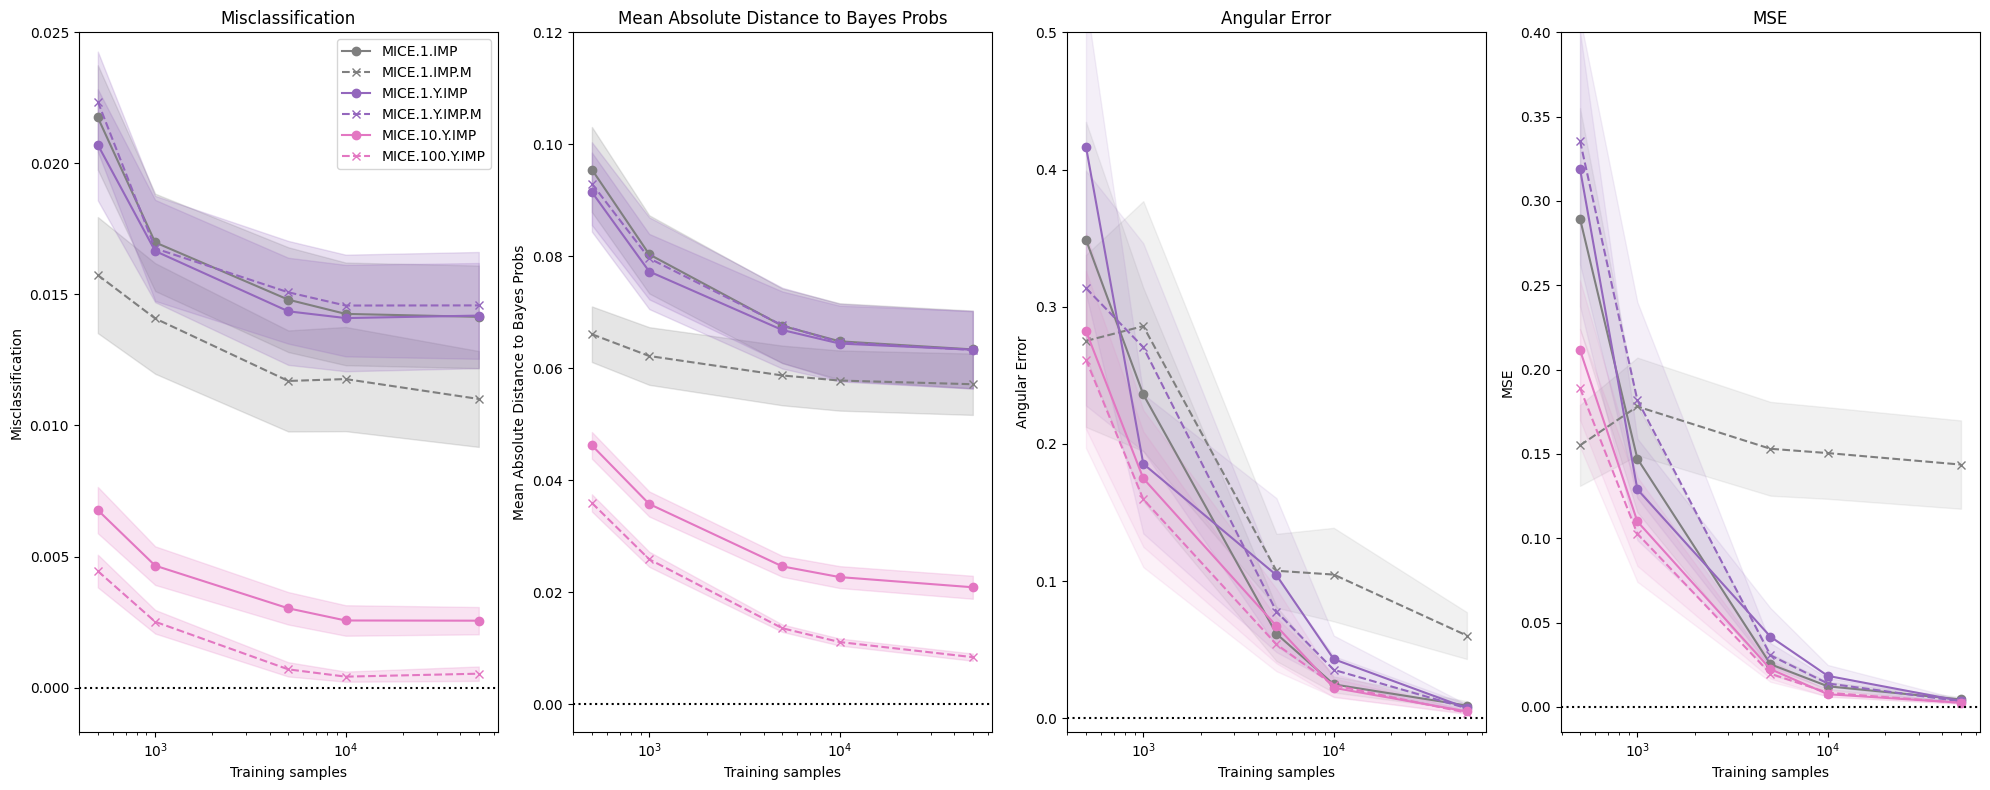

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
from utils import *
from setups import uncertainties, methods_config, metrics_config, variable_config, methods_no_pred_estimate, uncertainties_config, metrics_set_up, methods_no_beta_estimate

exp = "ExpA"

simulation_set_up = pd.read_csv(os.path.join("data", exp, "simulation_set_up.csv"))


def plot_one_subplot_pred(
        ax,
        df,
        metric,
        uncertainty,
        pattern,
        pattern_probs,
        diff_bayes,
):
    all_methods = df["method"].unique()
    all_training_samples = df["n_train"].unique()

    dict_all_scores = {}

    for method in all_methods:
        dict_all_scores[method] = {}
        for n_train in all_training_samples:
            dict_all_scores[method][n_train] = []
            
    for i, row_set_up in df.iterrows():
        method = row_set_up["method"]
        n_train = row_set_up["n_train"]

        M = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["M"]
        idx_pattern = get_index_pattern(pattern, M, remove_all_missing=True)

        try:
            pred = np.load(os.path.join("data", exp, "pred_data",f"{row_set_up['file_name']}.npz"))["y_probs_pred"].ravel()
            pred = pred[idx_pattern] if pattern is not None else pred

            true = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["y_probs"].ravel()
            true = true[idx_pattern] if pattern is not None else true
            true_y = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["y"].ravel()
            true_y = true_y[idx_pattern] if pattern is not None else true_y

            bayes = np.load(os.path.join("data", exp, "bayes_data",f"{row_set_up['set_up']}.npz"))["y_probs_bayes"]
            bayes = bayes[idx_pattern] if pattern is not None else bayes

            if pattern_probs is not None:
                idx_pattern_probs = get_index_pattern_probs(pattern_probs, true, bayes)
                pred = pred[idx_pattern_probs]
                true = true[idx_pattern_probs]
                true_y = true_y[idx_pattern_probs]
                bayes = bayes[idx_pattern_probs]

            score = metrics_set_up[metric](true, pred, true_y, bayes)

            if diff_bayes:

                score -= metrics_set_up[metric](true, bayes, true_y, bayes)

            dict_all_scores[method][n_train].append(score)
        except:
            pass

    dict_mean_scores = {}
    dict_uncertainty_scores = {}
    for method in all_methods:
        dict_mean_scores[method] = {}
        dict_uncertainty_scores[method] = {}
    
        for n_train in all_training_samples:
            if len(dict_all_scores[method][n_train]) == 0:
                dict_mean_scores[method][n_train] = np.nan
                dict_uncertainty_scores[method][n_train] = np.nan
            else:
                dict_mean_scores[method][n_train] = np.mean(dict_all_scores[method][n_train])
                dict_uncertainty_scores[method][n_train] = uncertainties[uncertainty](dict_all_scores[method][n_train])
        
    for method in all_methods:
        
        x = dict_mean_scores[method].keys() #n_train
        y = [dict_mean_scores[method][n_train] for n_train in x]

        yerr = [dict_uncertainty_scores[method][n_train] for n_train in x]
        ax.plot(x, y, label=methods_config[method]["label"], color=methods_config[method]["color"], 
                linestyle=methods_config[method]["linestyle"], marker=methods_config[method]["marker"])
        ax.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.2, 
                        color=methods_config[method]["color"])

    return ax

def plot_multiple_metrics(
        data,
        metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
        uncertainty="se",
        pattern=None,
        pattern_probs=None,
        diff_bayes=False,
        log_x=True,
        log_y=False,
        min_y=None,
        max_y=None,
        select_methods=None,
        remove_methods=None,
        save=None,
        size_height=5,
        size_width=5,
        **kwargs
):
    
    if uncertainty is None:
        uncertainty = "se"
        flag_print_uncertainty = False
    else:
        flag_print_uncertainty = True
    
    df = filter_data(data, **kwargs)
    methods = df["method"].unique()
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]

    print(methods)

    df = df[df["method"].isin(methods)]
    
    fig, axs = plt.subplots(1, len(metrics), figsize=(size_width * len(metrics), size_height))
    if len(metrics) == 1:
        axs = [axs]
    
    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        if metric in ["missclassification_error", "mae_score_bayes", "brier_score", "mae_score"]:
            plot_one_subplot_pred(ax, df, metric, uncertainty, pattern, pattern_probs, diff_bayes)
        else:
            df_metric = df[[metric, "method", "n_train"]]
            df_metric.loc[:,metric] = df_metric[metric].astype(float)
            df_metric = df_metric.groupby(["method", "n_train"]).agg(
                {metric: ["mean", uncertainties[uncertainty]]}
            ).reset_index()
            df_metric.columns = ["method", "n_train", "mean", uncertainty]
            
            for method in methods:
                if method in methods_no_beta_estimate and metric != "running_time":
                    continue
                df_ = df_metric[df_metric["method"] == method]
                x = df_["n_train"]
                y = df_["mean"]
                yerr = df_[uncertainty]
                
                ax.plot(x, y, label=methods_config[method]["label"],
                         color=methods_config[method]["color"],
                         marker=methods_config[method]["marker"],
                         linestyle=methods_config[method]["linestyle"])
                ax.fill_between(x, y - yerr, y + yerr, color=methods_config[method]["color"], alpha=0.1)
        
        ax.set_xlabel("Training samples")
        if flag_print_uncertainty:
            ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
        else:
            ax.set_ylabel(metrics_config[metric]["label"])
        
        ax.set_ylim(min_y[i], max_y[i])
        ax.axhline(0, color="black", linestyle=":")
        
        # set title
        ax.set_title(metrics_config[metric]["label"])
        
        if log_x:
            ax.set_xscale("log")
        if log_y:
            ax.set_yscale("log")
        
        if i == 0:
            ax.legend()
        
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()



# remove_methods=["MICE.IMP", "MICE.M.IMP",  "MICE.M.IMP", "05.IMP.M", "MICE.Y.M.IMP", "PY.SAEM"]
remove_methods = None
# select_methods = None
# select_methods= ["05.IMP", "Mean.IMP", "Mean.IMP.M", "PbP", "CC", "MICE.Y.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP", "SAEM"]
select_methods= ["MICE.IMP", "MICE.M.IMP", "MICE.Y.IMP", "MICE.Y.M.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP"]


plot_multiple_metrics(

    simulation_set_up,
    metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
    # metrics = ["missclassification_error", "angular_error"],
    uncertainty=None,
    pattern=None,
    pattern_probs=None,
    diff_bayes=True,
    
    log_x=True,
    log_y=False,
    min_y=[-0.0017, -0.005,  -0.01, -0.015],
    max_y=[0.025, 0.12, 0.5, 0.4],
    # min_y = [-0.002, -0.01],
    # max_y = [0.020, 0.50],

    
    select_methods=select_methods,
    remove_methods=remove_methods,

    save="data/ExpA/figures/all_scores_MICE.pdf",
    
    size_height=8,
    size_width=5,
    
    #

)

['CC', '05.IMP', 'Mean.IMP', 'Mean.IMP.M', 'PbP', 'MICE.Y.IMP', 'SAEM']


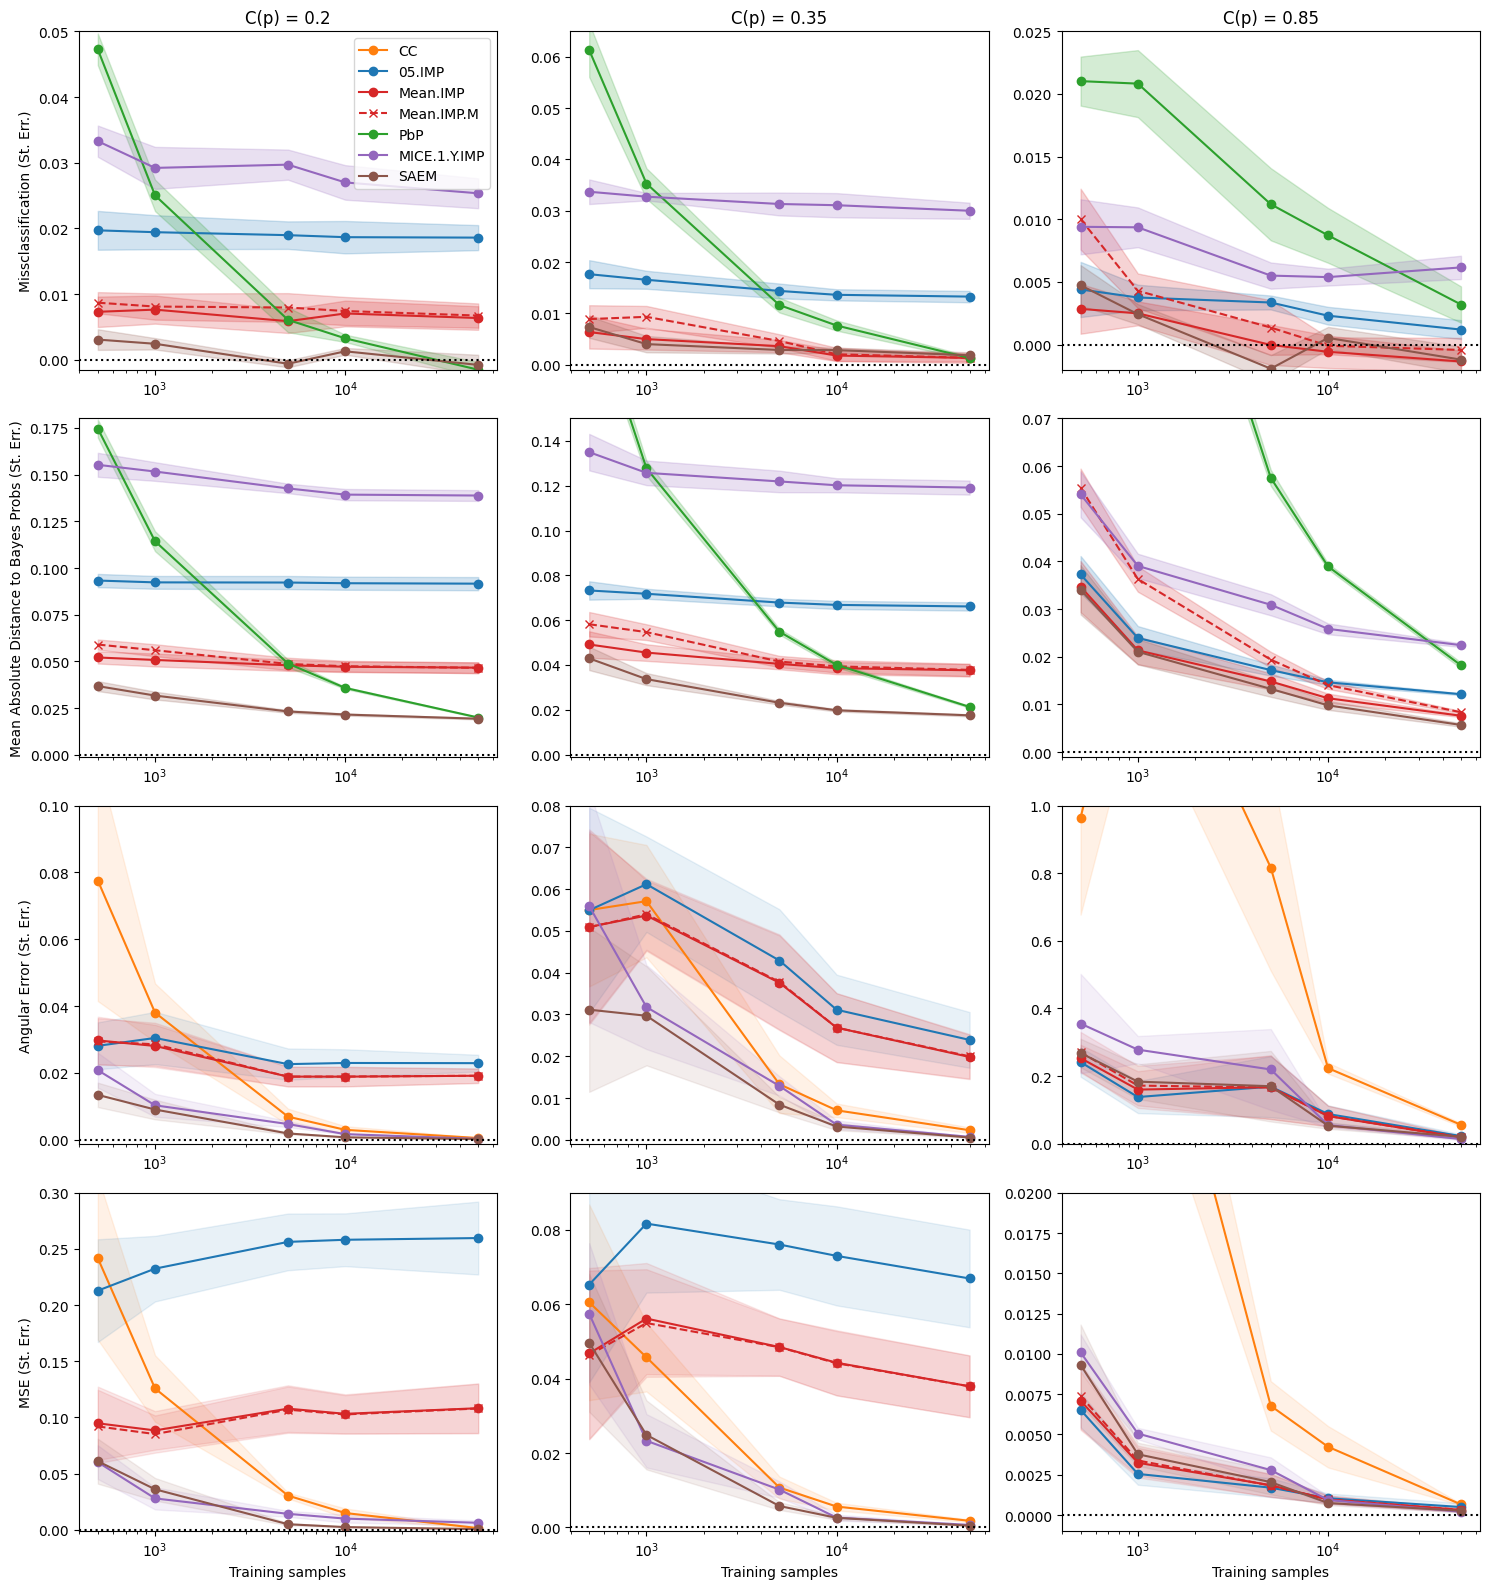

In [12]:
def plot_multiple_metrics(
        data,
        metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
        uncertainty="se",
        pattern=None,
        pattern_probs=None,
        diff_bayes=False,
        log_x=True,
        log_y=False,
        min_y=None,
        max_y=None,
        select_methods=None,
        remove_methods=None,
        save=None,
        size_height=5,
        size_width=5,
        centricities=[0.2, 0.35, 0.85],
        **kwargs
):
    # Filter the data using kwargs (including centricity)
    df = filter_data(data, **kwargs)
    methods = df["method"].unique()
    
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]

    print(methods)

    df = df[df["method"].isin(methods)]
    
    # Create a 4x3 grid for the plots
    fig, axs = plt.subplots(len(metrics), len(centricities), figsize=(size_width * len(centricities), size_height * len(metrics)))

    # Ensure axs is iterable (even if only one metric is passed)
    if len(metrics) == 1:
        axs = [axs]

    # Iterate through each metric
    for i, metric in enumerate(metrics):
        for j, centricity in enumerate(centricities):
            ax = axs[i][j] if len(centricities) > 1 else axs[i]

            # Filter df by centricity value
            df_cent = df[df["centricity"] == centricity]
            
            if metric in ["missclassification_error", "mae_score_bayes", "brier_score", "mae_score"]:
                plot_one_subplot_pred(ax, df_cent, metric, uncertainty, pattern, pattern_probs, diff_bayes)
            else:
                df_metric = df_cent[[metric, "corr", "method", "n_train"]]
                df_metric.loc[:,metric] = df_metric[metric].astype(float)
                df_metric = df_metric.groupby(["method", "n_train"]).agg(
                    {metric: ["mean", uncertainties[uncertainty]]}
                ).reset_index()
                df_metric.columns = ["method", "n_train", "mean", uncertainty]
                
                for method in methods:
                    if method in methods_no_beta_estimate and metric != "running_time":
                        continue
                    df_ = df_metric[df_metric["method"] == method]
                    x = df_["n_train"]
                    y = df_["mean"]
                    yerr = df_[uncertainty]
                    
                    ax.plot(x, y, label=methods_config[method]["label"],
                             color=methods_config[method]["color"],
                             marker=methods_config[method]["marker"],
                             linestyle=methods_config[method]["linestyle"])
                    ax.fill_between(x, y - yerr, y + yerr, color=methods_config[method]["color"], alpha=0.1)

            if i == len(metrics) - 1:
                ax.set_xlabel("Training samples")

            if j == 0:
                ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
            
            # Set y limits for each plot
            if min_y and max_y:
                # if 1 min y per metric
                if len(min_y) == len(metrics):
                    ax.set_ylim(min_y[i], max_y[i])
                # if 1 min y per metric and centricity
                elif len(min_y) == len(metrics) * len(centricities):
                    ax.set_ylim(min_y[i*len(centricities) + j], max_y[i*len(centricities) + j])
            ax.axhline(0, color="black", linestyle=":")

            # Set title for each subplot
            if i == 0:
                ax.set_title(f"C(p) = {centricity}")
            
            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")
            
            # Add legend only for the first column
            if j == 0 and i == 0:
                ax.legend()

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()



# remove_methods=["MICE.IMP", "MICE.M.IMP",  "MICE.M.IMP", "05.IMP.M", "MICE.Y.M.IMP", "PY.SAEM"]
remove_methods = None
# select_methods = None
select_methods= ["05.IMP", "Mean.IMP", "Mean.IMP.M", "PbP", "CC", "MICE.Y.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP", "SAEM"]


plot_multiple_metrics(

    simulation_set_up,
    metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
    uncertainty="se",
    pattern=None,
    pattern_probs=None,
    diff_bayes=True,
    
    log_x=True,
    log_y=False,
    min_y=[-0.0015, -0.001, -0.002,
           -0.001, -0.001, -0.001,
           -0.0013, -0.001, -0.001,
           -0.0013, -0.001, -0.001],
    max_y=[0.05, 0.065, 0.025,
           0.18, 0.15, 0.07,
           0.10, 0.08, 1,
           0.30, 0.09, 0.02],

    select_methods=select_methods,
    remove_methods=remove_methods,

    save="data/ExpB/figures/all_scores.pdf",
    
    size_height=4,
    size_width=5,
    
    #


)

['SAEM', 'CC', '05.IMP', 'Mean.IMP', 'Mean.IMP.M', 'PbP', 'MICE.Y.IMP', 'MICE.10.Y.IMP', 'MICE.100.Y.IMP']


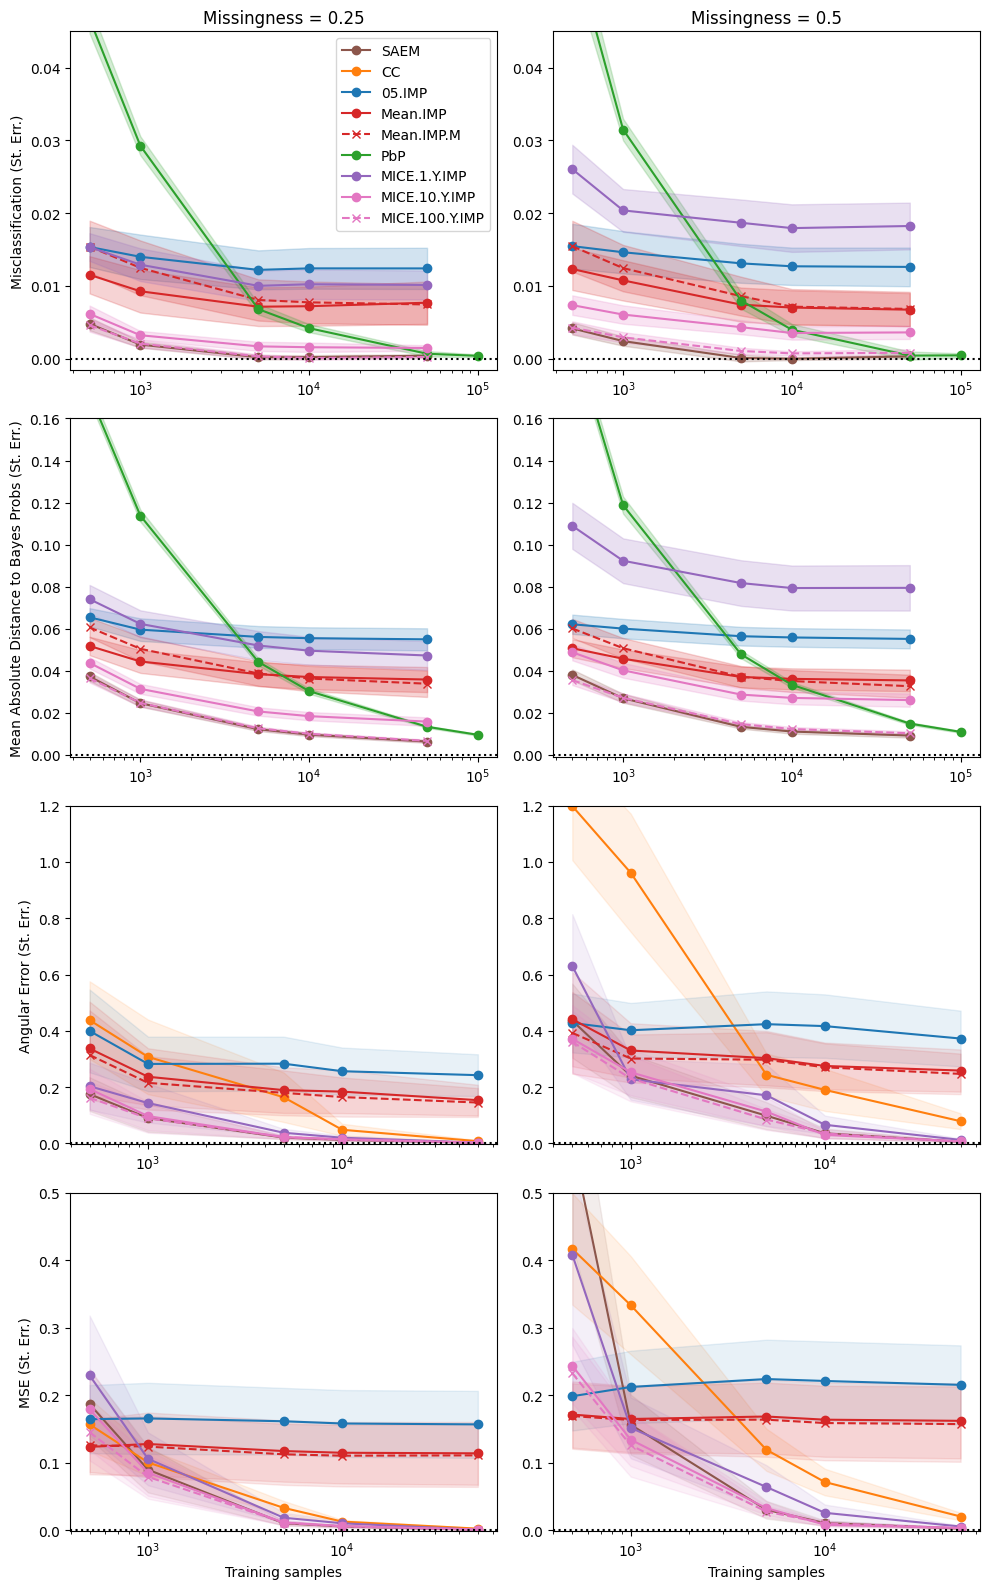

In [36]:
def plot_multiple_metrics(
        data,
        metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
        uncertainty="se",
        pattern=None,
        pattern_probs=None,
        diff_bayes=False,
        log_x=True,
        log_y=False,
        min_y=None,
        max_y=None,
        select_methods=None,
        remove_methods=None,
        save=None,
        size_height=5,
        size_width=5,
        **kwargs
):
    # Filter the data using kwargs (including centricity)
    df = data.copy()
    methods = df["method"].unique()
    
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]

    print(methods)

    df = df[df["method"].isin(methods)]

    metrics_filtering = list(kwargs.keys())[0]
    metrics_values = kwargs[metrics_filtering]
    
    # Create a 4x3 grid for the plots
    fig, axs = plt.subplots(len(metrics), len(metrics_values), figsize=(size_width * len(metrics_values), size_height * len(metrics)))

    # Ensure axs is iterable (even if only one metric is passed)
    if len(metrics) == 1:
        axs = [axs]

    # Iterate through each metric
    for i, metric in enumerate(metrics):
        for j, centricity in enumerate(metrics_values):
            ax = axs[i][j] if len(metrics_values) > 1 else axs[i]

            df_cent = df[df[metrics_filtering] == centricity]
            
            if metric in ["missclassification_error", "mae_score_bayes", "brier_score", "mae_score"]:
                plot_one_subplot_pred(ax, df_cent, metric, uncertainty, pattern, pattern_probs, diff_bayes)
            else:
                df_metric = df_cent[[metric, "corr", "method", "n_train"]]
                df_metric.loc[:,metric] = df_metric[metric].astype(float)
                df_metric = df_metric.groupby(["method", "n_train"]).agg(
                    {metric: ["mean", uncertainties[uncertainty]]}
                ).reset_index()
                df_metric.columns = ["method", "n_train", "mean", uncertainty]
                
                for method in methods:
                    if method in methods_no_beta_estimate and metric != "running_time":
                        continue
                    df_ = df_metric[df_metric["method"] == method]
                    x = df_["n_train"]
                    y = df_["mean"]
                    yerr = df_[uncertainty]
                    
                    ax.plot(x, y, label=methods_config[method]["label"],
                             color=methods_config[method]["color"],
                             marker=methods_config[method]["marker"],
                             linestyle=methods_config[method]["linestyle"])
                    ax.fill_between(x, y - yerr, y + yerr, color=methods_config[method]["color"], alpha=0.1)

            if i == len(metrics) - 1:
                ax.set_xlabel("Training samples")

            if j == 0:
                ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
            
            # Set y limits for each plot
            if min_y and max_y:
                # if 1 min y per metric
                if len(min_y) == len(metrics):
                    ax.set_ylim(min_y[i], max_y[i])
                # if 1 min y per metric and centricity
                elif len(min_y) == len(metrics) * len(metrics_values):
                    ax.set_ylim(min_y[i*len(metrics_values) + j], max_y[i*len(metrics_values) + j])
            ax.axhline(0, color="black", linestyle=":")

            # Set title for each subplot
            if i == 0:
                ax.set_title(f"{variable_config[metrics_filtering]['label']} = {centricity}")
            
            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")
            
            # Add legend only for the first column
            if j == 0 and i == 0:
                ax.legend()

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()



# remove_methods=["MICE.IMP", "MICE.M.IMP",  "MICE.M.IMP", "05.IMP.M", "MICE.Y.M.IMP", "PY.SAEM"]
remove_methods = None
# select_methods = None
select_methods= ["05.IMP", "Mean.IMP", "Mean.IMP.M", "PbP", "CC", "MICE.Y.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP", "SAEM"]


plot_multiple_metrics(

    simulation_set_up,
    metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
    uncertainty="se",
    pattern=None,
    pattern_probs=None,
    diff_bayes=True,
    
    log_x=True,
    log_y=False,
    min_y=[-0.0015, -0.001, -0.002,-0.001],
    max_y=[0.045, 0.16, 1.2, 0.5],

    select_methods=select_methods,
    remove_methods=remove_methods,

    save="data/ExpA/figures/all_scores_prcNA.pdf",
    
    size_height=4,
    size_width=5,
    
    #

    prcNA = [0.25, 0.50]

)

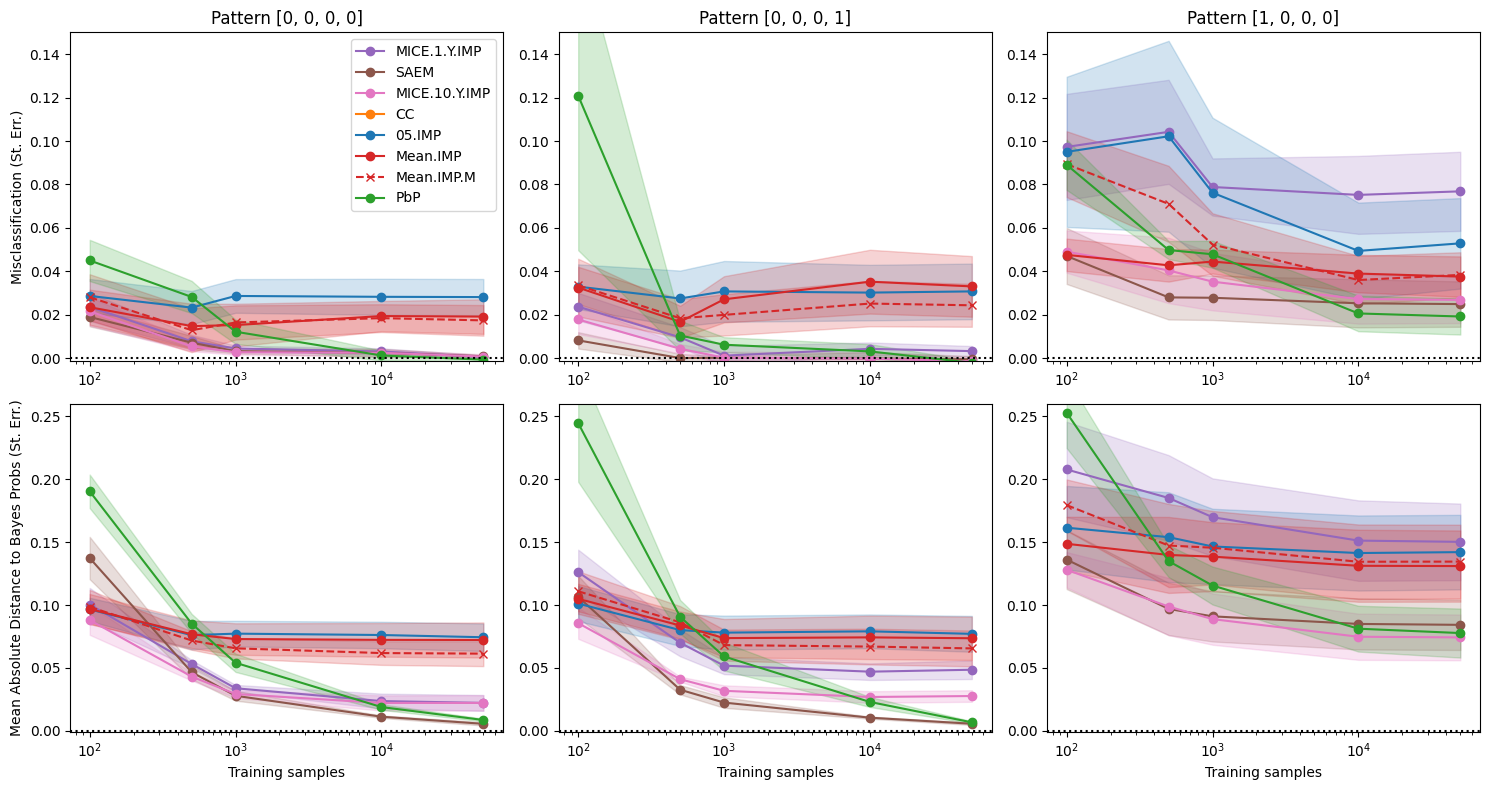

In [8]:
def plot_multiple_metrics_patterns(
        data,
        metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
        uncertainty="se",
        patterns=None,
        diff_bayes=False,
        log_x=True,
        log_y=False,
        min_y=None,
        max_y=None,
        select_methods=None,
        remove_methods=None,
        save=None,
        size_height=5,
        size_width=5,
        **kwargs
):
    # Ensure patterns is a list
    if patterns is None:
        patterns = [0, 2, 4]

    # Filter data
    df = filter_data(data, **kwargs)
    methods = df["method"].unique()
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]
    
    df = df[df["method"].isin(methods)]

    # Create a grid for the plots
    fig, axs = plt.subplots(len(metrics), len(patterns), figsize=(size_width * len(patterns), size_height * len(metrics)))

    if len(metrics) == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        for j, pattern in enumerate(patterns):
            ax = axs[i][j] if len(patterns) > 1 else axs[i]


            if metric in ["missclassification_error", "mae_score_bayes", "brier_score", "mae_score"]:
                plot_one_subplot_pred(ax, df, metric, uncertainty, pattern, None, diff_bayes)
            else:
                df_metric = df[[metric, "corr", "method", "n_train"]].copy()
                df_metric[metric] = df_metric[metric].astype(float)
                df_metric = df_metric.groupby(["method", "n_train"]).agg(
                    {metric: ["mean", uncertainties[uncertainty]]}
                ).reset_index()
                df_metric.columns = ["method", "n_train", "mean", uncertainty]

                for method in methods:
                    if method in methods_no_beta_estimate and metric != "running_time":
                        continue
                    df_ = df_metric[df_metric["method"] == method]
                    x = df_["n_train"]
                    y = df_["mean"]
                    yerr = df_[uncertainty]

                    ax.plot(x, y, label=methods_config[method]["label"],
                            color=methods_config[method]["color"],
                            marker=methods_config[method]["marker"],
                            linestyle=methods_config[method]["linestyle"])
                    ax.fill_between(x, y - yerr, y + yerr, color=methods_config[method]["color"], alpha=0.1)

            if i == len(metrics) - 1:
                ax.set_xlabel("Training samples")

            if j == 0:
                ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")

            # Set y limits
            if min_y and max_y:
                if len(min_y) == len(metrics):
                    ax.set_ylim(min_y[i], max_y[i])
                elif len(min_y) == len(metrics) * len(patterns):
                    ax.set_ylim(min_y[i * len(patterns) + j], max_y[i * len(patterns) + j])
            ax.axhline(0, color="black", linestyle=":")

            if i == 0:
                ax.set_title(f"Pattern {pattern}")

            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")

            if j == 0 and i == 0:
                ax.legend()

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()


# remove_methods=["MICE.IMP", "MICE.M.IMP",  "MICE.M.IMP", "05.IMP.M", "MICE.Y.M.IMP", "PY.SAEM"]
remove_methods = None
# select_methods = None
select_methods= ["05.IMP", "Mean.IMP", "Mean.IMP.M", "PbP", "CC", "MICE.Y.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP", "SAEM"]

plot_multiple_metrics_patterns(
    
    simulation_set_up,
    metrics=["missclassification_error", "mae_score_bayes"],
    uncertainty="se",
    patterns=[[0,0,0,0],[0,0,0,1], [1,0,0,0]],
    diff_bayes=True,
    
    log_x=True,
    log_y=False,

    max_y=[0.15,0.26],
    min_y=[-0.001, -0.001],

    select_methods=select_methods,
    remove_methods=remove_methods,

    save="data/ExpD/figures/missclass_mae_bayes_patterns.pdf",
    
    size_height=4,
    size_width=5,
    
    #

)


['MICE.Y.IMP', 'SAEM', 'MICE.10.Y.IMP', 'CC', '05.IMP', 'Mean.IMP', 'Mean.IMP.M', 'PbP']


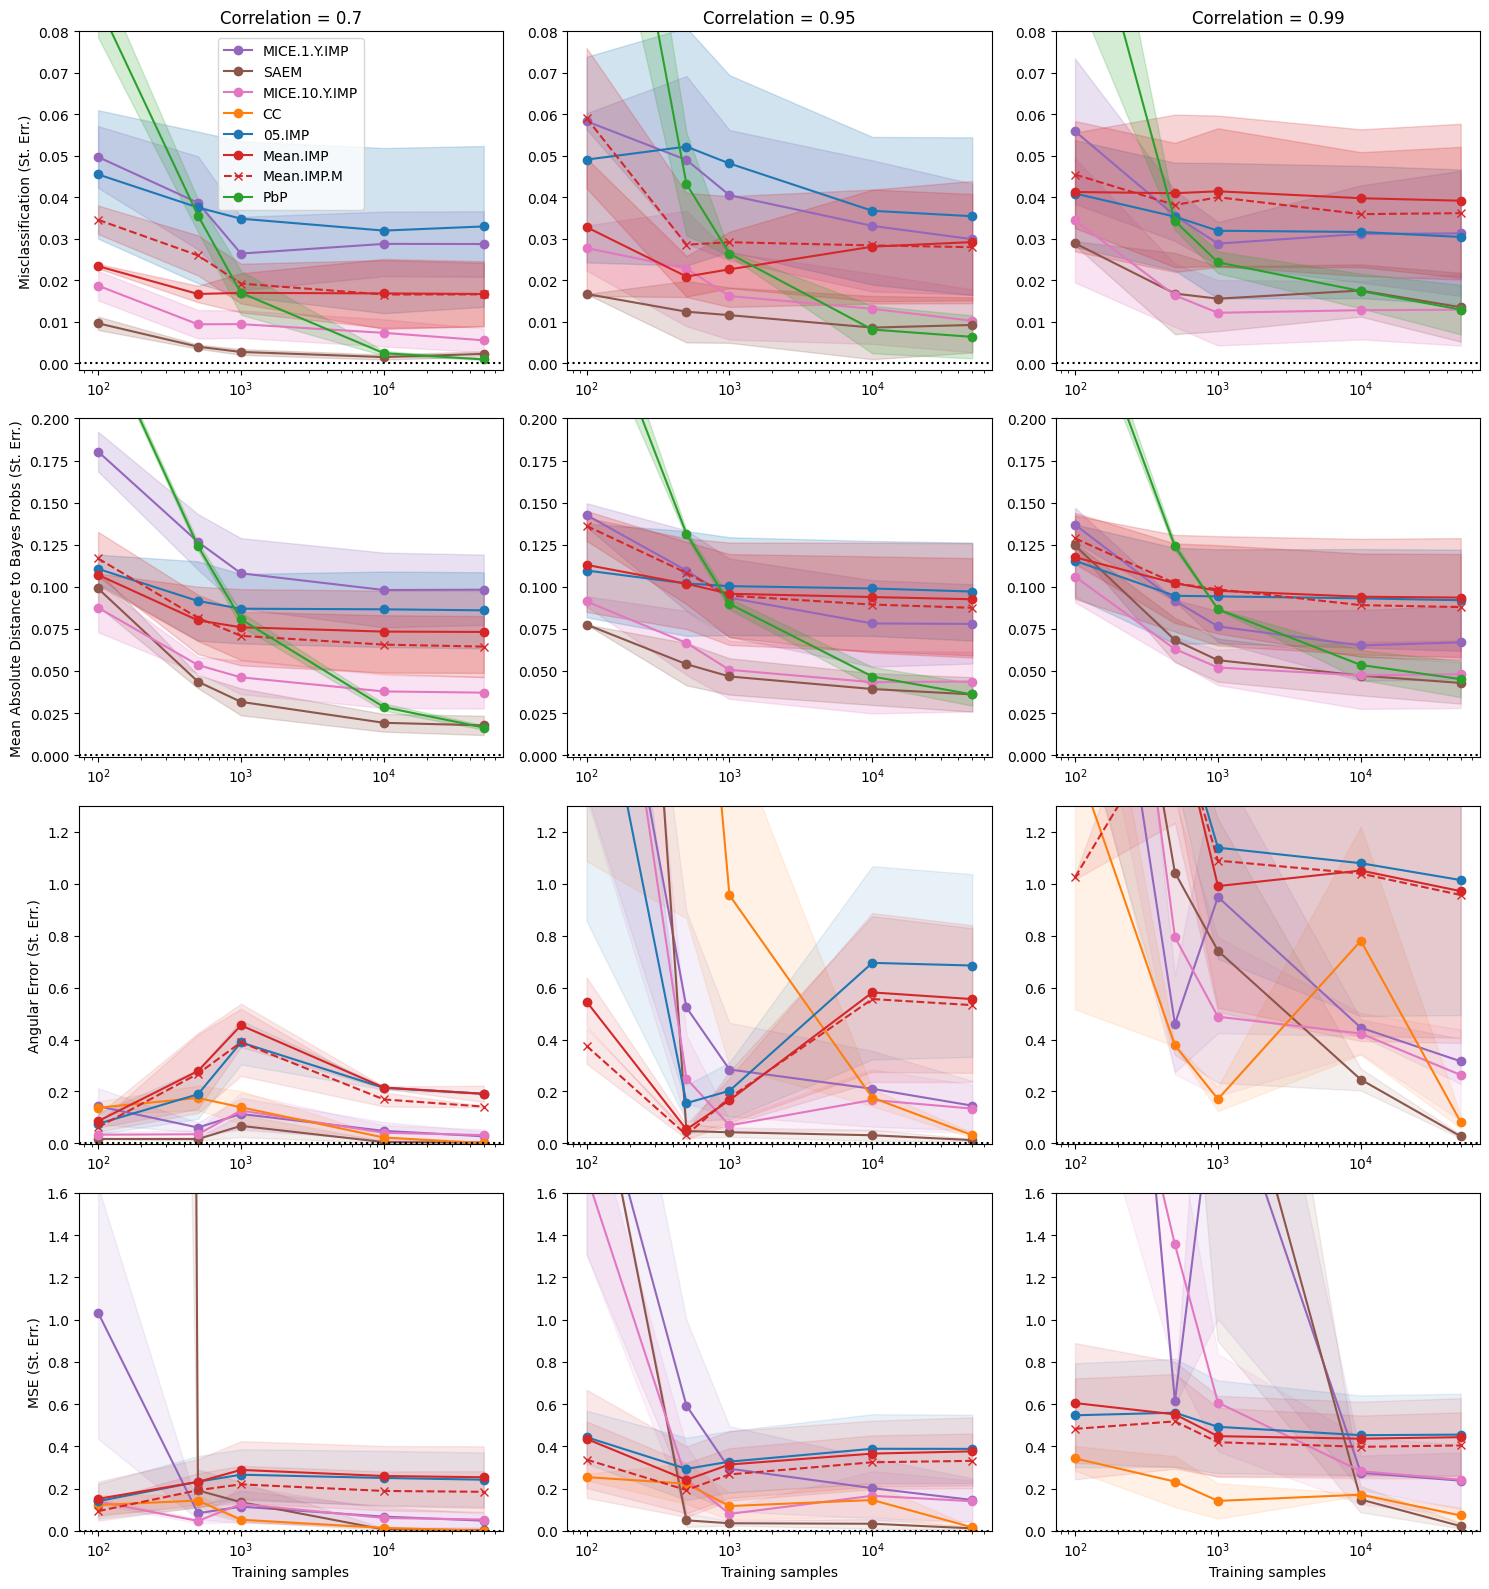

In [14]:
def plot_multiple_metrics(
        data,
        metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
        uncertainty="se",
        pattern=None,
        pattern_probs=None,
        diff_bayes=False,
        log_x=True,
        log_y=False,
        min_y=None,
        max_y=None,
        select_methods=None,
        remove_methods=None,
        save=None,
        size_height=5,
        size_width=5,
        corrs=[0.7,0.95,0.99],
        **kwargs
):
    # Filter the data using kwargs (including centricity)
    df = filter_data(data, **kwargs)
    methods = df["method"].unique()
    
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]

    print(methods)

    df = df[df["method"].isin(methods)]
    
    # Create a 4x3 grid for the plots
    fig, axs = plt.subplots(len(metrics), len(corrs), figsize=(size_width * len(corrs), size_height * len(metrics)))

    # Ensure axs is iterable (even if only one metric is passed)
    if len(metrics) == 1:
        axs = [axs]

    # Iterate through each metric
    for i, metric in enumerate(metrics):
        for j, corr in enumerate(corrs):
            ax = axs[i][j] if len(corrs) > 1 else axs[i]

            # Filter df by centricity value
            df_cent = df[df["corr"] == corr]
            
            if metric in ["missclassification_error", "mae_score_bayes", "brier_score", "mae_score"]:
                plot_one_subplot_pred(ax, df_cent, metric, uncertainty, pattern, pattern_probs, diff_bayes)
            else:
                df_metric = df_cent[[metric, "corr", "method", "n_train"]]
                df_metric.loc[:,metric] = df_metric[metric].astype(float)
                df_metric = df_metric.groupby(["method", "n_train"]).agg(
                    {metric: ["mean", uncertainties[uncertainty]]}
                ).reset_index()
                df_metric.columns = ["method", "n_train", "mean", uncertainty]
                
                for method in methods:
                    if method in methods_no_beta_estimate and metric != "running_time":
                        continue
                    df_ = df_metric[df_metric["method"] == method]
                    x = df_["n_train"]
                    y = df_["mean"]
                    yerr = df_[uncertainty]
                    
                    ax.plot(x, y, label=methods_config[method]["label"],
                             color=methods_config[method]["color"],
                             marker=methods_config[method]["marker"],
                             linestyle=methods_config[method]["linestyle"])
                    ax.fill_between(x, y - yerr, y + yerr, color=methods_config[method]["color"], alpha=0.1)

            if i == len(metrics) - 1:
                ax.set_xlabel("Training samples")

            if j == 0:
                ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
            
            # Set y limits for each plot
            if min_y and max_y:
                # if 1 min y per metric
                if len(min_y) == len(metrics):
                    ax.set_ylim(min_y[i], max_y[i])
                # if 1 min y per metric and centricity
                elif len(min_y) == len(metrics) * len(corrs):
                    ax.set_ylim(min_y[i*len(corrs) + j], max_y[i*len(corrs) + j])
            ax.axhline(0, color="black", linestyle=":")

            # Set title for each subplot
            if i == 0:
                ax.set_title(f"Correlation = {corr}")
            
            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")
            
            # Add legend only for the first column
            if j == 0 and i == 0:
                ax.legend()

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()



# remove_methods=["MICE.IMP", "MICE.M.IMP",  "MICE.M.IMP", "05.IMP.M", "MICE.Y.M.IMP", "PY.SAEM"]
remove_methods = None
# select_methods = None
select_methods= ["05.IMP", "Mean.IMP", "Mean.IMP.M", "PbP", "CC", "MICE.Y.IMP", "MICE.10.Y.IMP", "MICE.100.Y.IMP", "SAEM"]


plot_multiple_metrics(

    simulation_set_up,
    metrics=["missclassification_error", "mae_score_bayes", "angular_error", "mse_error"],
    uncertainty="se",
    pattern=None,
    pattern_probs=None,
    diff_bayes=True,
    
    log_x=True,
    log_y=False,
    min_y=[-0.0015, -0.001, -0.002, -0.001],
    max_y=[0.08, 0.2, 1.3, 1.6],

    select_methods=select_methods,
    remove_methods=remove_methods,

    save="data/ExpD/figures/correlations.pdf",
    
    size_height=4,
    size_width=5,
    
    #


)